In [1]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Import our input dataset
charity_df = pd.read_csv('charity_data.csv')
charity_df

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,996009318,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,996010315,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,996012607,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,996015768,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


# Preprocessing
After looking at the csv it is clear that "is_sucessful" is the target, "ein" and "name" are just id tags, so that leaves the rest of the columns as features.

In [2]:
charity_df = charity_df.drop(["EIN"],1)

# Generate our categorical variable list
charity_cat = charity_df.dtypes[charity_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
unique_counts = charity_df[charity_cat].nunique()
display(unique_counts)

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
dtype: int64

In [3]:
def bucketing(column, data=charity_df, bucket_size=10):
    
    bucket = data[column].value_counts()

    # Determine which values to replace
    replace_col = list(bucket[bucket < bucket_size].index)

    # Replace in DataFrame
    for app in replace_col:
        charity_df[column] = charity_df[column].replace(app, "Other")
    
    return

bucketing("NAME")
bucketing("APPLICATION_TYPE")
bucketing("CLASSIFICATION")

# Model Testing
### We have bucketed values appropriately so now we need to encode the dataframe.

In [4]:
def model_testing(data = charity_df, goal = .78, filter_epoch = 20, final_epoch = 100):
          
    charity_cat = data.dtypes[data.dtypes == "object"].index.tolist()

    # Create the OneHotEncoder instance
    enc = OneHotEncoder(sparse=False)

    # Fit the encoder and produce encoded DataFrame
    encode_df = pd.DataFrame(enc.fit_transform(data[charity_cat]))

    # Rename encoded columns
    encode_df.columns = enc.get_feature_names(charity_cat)

    # Merge the two DataFrames together and drop the Country column
    data = data.merge(encode_df,left_index=True,right_index=True).drop(charity_cat, 1)

    # Split our preprocessed data into our features and target arrays
    y = data["IS_SUCCESSFUL"].values
    X = data.drop(["IS_SUCCESSFUL"],1).values

    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    activations = ['relu', 'sigmoid', 'tanh']
    filtered_models = []
    
    for hidden_nodes_layer1 in range(100,300,20):
        for hidden_nodes_layer2 in range(1,hidden_nodes_layer1,10):
            for layer1_activation in activations:
                for layer2_activation in activations:   

                    nn = tf.keras.models.Sequential()

                    # First hidden layer
                    nn.add(tf.keras.layers.Dense(units=len(X_train[0])*hidden_nodes_layer1//100, input_dim=len(X_train[0]), activation=layer1_activation))

                    # Second hidden layer
                    nn.add(tf.keras.layers.Dense(units=len(X_train[0])*hidden_nodes_layer2//100, activation=layer2_activation))

                    # Output layer
                    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

                    # Compile the model
                    nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

                    # Train the model
                    fit_model = nn.fit(X_train_scaled,y_train,epochs=filter_epoch)

                    # Evaluate the model using the test data
                    model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)

                    filtered_models = []

                    if model_accuracy >= goal:

                        filtered_model = [hidden_nodes_layer1, hidden_nodes_layer2, layer1_activation, layer2_activation]

                        filtered_models.append(filtered_model)
        
    best_model = [0]
    
    for model in filtered_models:
        
        nn = tf.keras.models.Sequential()

        # First hidden layer
        nn.add(tf.keras.layers.Dense(units=model[0], input_dim=len(X_train[0]), activation=model[2]))

        # Second hidden layer
        nn.add(tf.keras.layers.Dense(units=model[1], activation=model[3]))

        # Output layer
        nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

        # Compile the model
        nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        # Train the model
        fit_model = nn.fit(X_train_scaled,y_train,epochs=final_epoch)

        # Evaluate the model using the test data
        model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)        
        
        if model_accuracy > best_model[0]:
            
            best_model = [model_accuracy, model]
        
    nn = tf.keras.models.Sequential()

    # First hidden layer
    nn.add(tf.keras.layers.Dense(units=best_model[1][0], input_dim=len(X_train[0]), activation=best_model[1][2]))

    # Second hidden layer
    nn.add(tf.keras.layers.Dense(units=best_model[1][1], activation=best_model[1][3]))

    # Output layer
    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Train the model
    fit_model = nn.fit(X_train_scaled,y_train,epochs=final_epoch)

    # Evaluate the model using the test data
    model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
    
    # Export our model to HDF5 file
    nn_new.save("trained_charity.h5")

    # Import the model to a new object
    nn_imported = tf.keras.models.load_model('trained_charity.h5')

    # Evaluate the model using the test data
    model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    
    return best_model

In [5]:
best_model = model_testing()

Epoch 1/20
804/804 [==============================] - 2s 2ms/step - loss: 0.5064 - accuracy: 0.7351
Epoch 2/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4800 - accuracy: 0.7399
Epoch 3/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4756 - accuracy: 0.7420
Epoch 4/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4737 - accuracy: 0.7449
Epoch 5/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4684 - accuracy: 0.7551
Epoch 6/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4657 - accuracy: 0.7559
Epoch 7/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4647 - accuracy: 0.7576
Epoch 8/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4622 - accuracy: 0.7604
Epoch 9/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4623 - accuracy: 0.7598
Epoch 10/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4611 - accuracy: 0.7616

804/804 [==============================] - 1s 2ms/step - loss: 0.4385 - accuracy: 0.7874
Epoch 19/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4371 - accuracy: 0.7892
Epoch 20/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4362 - accuracy: 0.7906
268/268 - 0s - loss: 0.4478 - accuracy: 0.7811
Epoch 1/20
804/804 [==============================] - 1s 2ms/step - loss: 0.5731 - accuracy: 0.7427
Epoch 2/20
804/804 [==============================] - 2s 2ms/step - loss: 0.5147 - accuracy: 0.7850
Epoch 3/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4930 - accuracy: 0.7841
Epoch 4/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4796 - accuracy: 0.7834
Epoch 5/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4707 - accuracy: 0.7837
Epoch 6/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4649 - accuracy: 0.7841
Epoch 7/20
804/804 [==============================] - 1s 2ms/s

804/804 [==============================] - 2s 2ms/step - loss: 0.4352 - accuracy: 0.7897
Epoch 18/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4346 - accuracy: 0.7908
Epoch 19/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4332 - accuracy: 0.7911
Epoch 20/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4326 - accuracy: 0.7916
268/268 - 0s - loss: 0.4502 - accuracy: 0.7813
Epoch 1/20
804/804 [==============================] - 1s 2ms/step - loss: 0.5047 - accuracy: 0.7720
Epoch 2/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4728 - accuracy: 0.7785
Epoch 3/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4651 - accuracy: 0.7795
Epoch 4/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4578 - accuracy: 0.7814
Epoch 5/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4525 - accuracy: 0.7835
Epoch 6/20
804/804 [==============================] - 1s 2ms/

804/804 [==============================] - 2s 2ms/step - loss: 0.4288 - accuracy: 0.7921
Epoch 16/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4280 - accuracy: 0.7928
Epoch 17/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4284 - accuracy: 0.7933
Epoch 18/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4284 - accuracy: 0.7932
Epoch 19/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4283 - accuracy: 0.7923
Epoch 20/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4276 - accuracy: 0.7937
268/268 - 0s - loss: 0.4515 - accuracy: 0.7812
Epoch 1/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4762 - accuracy: 0.7688
Epoch 2/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4475 - accuracy: 0.7814
Epoch 3/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4445 - accuracy: 0.7832
Epoch 4/20
804/804 [==============================] - 2s 2m

804/804 [==============================] - 2s 2ms/step - loss: 0.4286 - accuracy: 0.7921
Epoch 14/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4280 - accuracy: 0.7935
Epoch 15/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4272 - accuracy: 0.7933
Epoch 16/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4264 - accuracy: 0.7941
Epoch 17/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4265 - accuracy: 0.7934
Epoch 18/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4252 - accuracy: 0.7954
Epoch 19/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4249 - accuracy: 0.7943
Epoch 20/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4243 - accuracy: 0.7948
268/268 - 0s - loss: 0.4516 - accuracy: 0.7846
Epoch 1/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4737 - accuracy: 0.7671
Epoch 2/20
804/804 [==============================] - 2s 

804/804 [==============================] - 2s 2ms/step - loss: 0.4283 - accuracy: 0.7913
Epoch 13/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4281 - accuracy: 0.7912
Epoch 14/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4270 - accuracy: 0.7929
Epoch 15/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4263 - accuracy: 0.7925
Epoch 16/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4253 - accuracy: 0.7930
Epoch 17/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4247 - accuracy: 0.7937
Epoch 18/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4245 - accuracy: 0.7944
Epoch 19/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4239 - accuracy: 0.7945
Epoch 20/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4231 - accuracy: 0.7951
268/268 - 0s - loss: 0.4510 - accuracy: 0.7816
Epoch 1/20
804/804 [==============================] - 2s

804/804 [==============================] - 2s 2ms/step - loss: 0.4335 - accuracy: 0.7856
Epoch 10/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4332 - accuracy: 0.7868
Epoch 11/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4322 - accuracy: 0.7889
Epoch 12/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4320 - accuracy: 0.7877
Epoch 13/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4314 - accuracy: 0.7896
Epoch 14/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4309 - accuracy: 0.7886
Epoch 15/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4300 - accuracy: 0.7882
Epoch 16/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4299 - accuracy: 0.7896
Epoch 17/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4282 - accuracy: 0.7900
Epoch 18/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4284 - accuracy: 0.7895
Ep

804/804 [==============================] - 2s 2ms/step - loss: 0.4334 - accuracy: 0.7895
Epoch 9/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4325 - accuracy: 0.7915
Epoch 10/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4313 - accuracy: 0.7914
Epoch 11/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4313 - accuracy: 0.7916
Epoch 12/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4301 - accuracy: 0.7913
Epoch 13/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4298 - accuracy: 0.7926
Epoch 14/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4293 - accuracy: 0.7924
Epoch 15/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4284 - accuracy: 0.7926
Epoch 16/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4275 - accuracy: 0.7945
Epoch 17/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4275 - accuracy: 0.7940
Epo

804/804 [==============================] - 2s 2ms/step - loss: 0.4377 - accuracy: 0.7841
Epoch 8/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4369 - accuracy: 0.7842
Epoch 9/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4360 - accuracy: 0.7849
Epoch 10/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4349 - accuracy: 0.7855
Epoch 11/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4344 - accuracy: 0.7858
Epoch 12/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4335 - accuracy: 0.7851
Epoch 13/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4327 - accuracy: 0.7855
Epoch 14/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4323 - accuracy: 0.7871
Epoch 15/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4315 - accuracy: 0.7869
Epoch 16/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4307 - accuracy: 0.7876
Epoc

804/804 [==============================] - 2s 2ms/step - loss: 0.4352 - accuracy: 0.7871
Epoch 7/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4338 - accuracy: 0.7889
Epoch 8/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4331 - accuracy: 0.7895
Epoch 9/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4308 - accuracy: 0.7902
Epoch 10/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4295 - accuracy: 0.7908
Epoch 11/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4287 - accuracy: 0.7912
Epoch 12/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4281 - accuracy: 0.7925
Epoch 13/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4265 - accuracy: 0.7934
Epoch 14/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4249 - accuracy: 0.7945
Epoch 15/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4247 - accuracy: 0.7944
Epoch

804/804 [==============================] - 2s 2ms/step - loss: 0.4439 - accuracy: 0.7810
Epoch 4/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4416 - accuracy: 0.7838
Epoch 5/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4391 - accuracy: 0.7833
Epoch 6/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4379 - accuracy: 0.7862
Epoch 7/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4365 - accuracy: 0.7855
Epoch 8/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4358 - accuracy: 0.7874
Epoch 9/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4356 - accuracy: 0.7870
Epoch 10/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4347 - accuracy: 0.7860
Epoch 11/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4335 - accuracy: 0.7870
Epoch 12/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4335 - accuracy: 0.7870
Epoch 13

804/804 [==============================] - 2s 2ms/step - loss: 0.4493 - accuracy: 0.7798
Epoch 3/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4461 - accuracy: 0.7829
Epoch 4/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4435 - accuracy: 0.7824
Epoch 5/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4414 - accuracy: 0.7853
Epoch 6/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4389 - accuracy: 0.7844
Epoch 7/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4372 - accuracy: 0.7880
Epoch 8/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4353 - accuracy: 0.7868
Epoch 9/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4338 - accuracy: 0.7885
Epoch 10/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4325 - accuracy: 0.7877
Epoch 11/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4309 - accuracy: 0.7885
Epoch 12/

804/804 [==============================] - 2s 3ms/step - loss: 0.4712 - accuracy: 0.7706
Epoch 2/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4460 - accuracy: 0.7811
Epoch 3/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4413 - accuracy: 0.7839
Epoch 4/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4381 - accuracy: 0.7855
Epoch 5/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4379 - accuracy: 0.7862
Epoch 6/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4355 - accuracy: 0.7872
Epoch 7/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4350 - accuracy: 0.7899
Epoch 8/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4350 - accuracy: 0.7870
Epoch 9/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4337 - accuracy: 0.7883
Epoch 10/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4324 - accuracy: 0.7879
Epoch 11/2

804/804 [==============================] - 2s 3ms/step - loss: 0.4297 - accuracy: 0.7896
268/268 - 0s - loss: 0.4606 - accuracy: 0.7783
Epoch 1/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4685 - accuracy: 0.7735
Epoch 2/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4461 - accuracy: 0.7820
Epoch 3/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4417 - accuracy: 0.7863
Epoch 4/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4392 - accuracy: 0.7865
Epoch 5/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4378 - accuracy: 0.7862
Epoch 6/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4356 - accuracy: 0.7880
Epoch 7/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4349 - accuracy: 0.7895
Epoch 8/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4344 - accuracy: 0.7888
Epoch 9/20
804/804 [==============================] - 2s 3ms/ste

804/804 [==============================] - 2s 3ms/step - loss: 0.4260 - accuracy: 0.7940
Epoch 20/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4253 - accuracy: 0.7946
268/268 - 0s - loss: 0.4575 - accuracy: 0.7820
Epoch 1/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4702 - accuracy: 0.7711
Epoch 2/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4463 - accuracy: 0.7837
Epoch 3/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4409 - accuracy: 0.7835
Epoch 4/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4385 - accuracy: 0.7858
Epoch 5/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4368 - accuracy: 0.7870
Epoch 6/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4357 - accuracy: 0.7876
Epoch 7/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4349 - accuracy: 0.7881
Epoch 8/20
804/804 [==============================] - 2s 3ms/st

804/804 [==============================] - 2s 3ms/step - loss: 0.4309 - accuracy: 0.7878
Epoch 18/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4306 - accuracy: 0.7860
Epoch 19/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4295 - accuracy: 0.7886
Epoch 20/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4288 - accuracy: 0.7881
268/268 - 0s - loss: 0.4513 - accuracy: 0.7822
Epoch 1/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4766 - accuracy: 0.7680
Epoch 2/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4489 - accuracy: 0.7812
Epoch 3/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4443 - accuracy: 0.7831
Epoch 4/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4422 - accuracy: 0.7836
Epoch 5/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4402 - accuracy: 0.7820
Epoch 6/20
804/804 [==============================] - 2s 3ms/

804/804 [==============================] - 2s 3ms/step - loss: 0.4263 - accuracy: 0.7939
Epoch 17/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4251 - accuracy: 0.7925
Epoch 18/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4247 - accuracy: 0.7952
Epoch 19/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4236 - accuracy: 0.7963
Epoch 20/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4235 - accuracy: 0.7934
268/268 - 0s - loss: 0.4512 - accuracy: 0.7794
Epoch 1/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4759 - accuracy: 0.7721
Epoch 2/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4438 - accuracy: 0.7835
Epoch 3/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4407 - accuracy: 0.7854
Epoch 4/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4382 - accuracy: 0.7862
Epoch 5/20
804/804 [==============================] - 2s 3ms

804/804 [==============================] - 2s 3ms/step - loss: 0.4320 - accuracy: 0.7879
Epoch 16/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4319 - accuracy: 0.7885
Epoch 17/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4310 - accuracy: 0.7895
Epoch 18/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4303 - accuracy: 0.7892
Epoch 19/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4302 - accuracy: 0.7893
Epoch 20/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4290 - accuracy: 0.7905
268/268 - 0s - loss: 0.4504 - accuracy: 0.7811
Epoch 1/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4802 - accuracy: 0.7657
Epoch 2/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4488 - accuracy: 0.7798
Epoch 3/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4446 - accuracy: 0.7823
Epoch 4/20
804/804 [==============================] - 2s 3m

804/804 [==============================] - 2s 3ms/step - loss: 0.4289 - accuracy: 0.7904
Epoch 15/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4274 - accuracy: 0.7911
Epoch 16/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4262 - accuracy: 0.7948
Epoch 17/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4255 - accuracy: 0.7923
Epoch 18/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4237 - accuracy: 0.7943
Epoch 19/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4231 - accuracy: 0.7930
Epoch 20/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4224 - accuracy: 0.7953
268/268 - 0s - loss: 0.4516 - accuracy: 0.7824
Epoch 1/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4785 - accuracy: 0.7678
Epoch 2/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4487 - accuracy: 0.7807
Epoch 3/20
804/804 [==============================] - 3s 3

804/804 [==============================] - 2s 3ms/step - loss: 0.4329 - accuracy: 0.7874
Epoch 14/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4312 - accuracy: 0.7907
Epoch 15/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4312 - accuracy: 0.7901
Epoch 16/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4306 - accuracy: 0.7905
Epoch 17/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4298 - accuracy: 0.7920
Epoch 18/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4299 - accuracy: 0.7915
Epoch 19/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4295 - accuracy: 0.7916
Epoch 20/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4289 - accuracy: 0.7919
268/268 - 0s - loss: 0.4575 - accuracy: 0.7783
Epoch 1/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4797 - accuracy: 0.7663
Epoch 2/20
804/804 [==============================] - 2s 

804/804 [==============================] - 2s 3ms/step - loss: 0.4296 - accuracy: 0.7914
Epoch 13/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4296 - accuracy: 0.7921
Epoch 14/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4286 - accuracy: 0.7922
Epoch 15/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4273 - accuracy: 0.7927
Epoch 16/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4266 - accuracy: 0.7927
Epoch 17/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4259 - accuracy: 0.7928
Epoch 18/20
804/804 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.79 - 2s 3ms/step - loss: 0.4249 - accuracy: 0.7920
Epoch 19/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4248 - accuracy: 0.7944
Epoch 20/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4243 - accuracy: 0.7944
268/268 - 0s - loss: 0.4519 - accuracy: 0.7826
Epoch 1/20
804

804/804 [==============================] - 3s 3ms/step - loss: 0.4313 - accuracy: 0.7888
Epoch 12/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4298 - accuracy: 0.7909
Epoch 13/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4302 - accuracy: 0.7914
Epoch 14/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4288 - accuracy: 0.7923
Epoch 15/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4272 - accuracy: 0.7935
Epoch 16/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4276 - accuracy: 0.7936
Epoch 17/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4270 - accuracy: 0.7938
Epoch 18/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4265 - accuracy: 0.7934
Epoch 19/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4254 - accuracy: 0.7931
Epoch 20/20
804/804 [==============================] - 2s 3ms/step - loss: 0.4246 - accuracy: 0.7941
26

804/804 [==============================] - 2s 3ms/step - loss: 0.4366 - accuracy: 0.7846
Epoch 11/20
804/804 [==============================] - 3s 3ms/step - loss: 0.4350 - accuracy: 0.7833
Epoch 12/20
804/804 [==============================] - 4s 5ms/step - loss: 0.4352 - accuracy: 0.7860
Epoch 13/20
804/804 [==============================] - 3s 4ms/step - loss: 0.4340 - accuracy: 0.7854
Epoch 14/20
804/804 [==============================] - 3s 4ms/step - loss: 0.4335 - accuracy: 0.7843
Epoch 15/20
804/804 [==============================] - 3s 4ms/step - loss: 0.4331 - accuracy: 0.7859
Epoch 16/20
804/804 [==============================] - 3s 4ms/step - loss: 0.4341 - accuracy: 0.7858
Epoch 17/20
804/804 [==============================] - 3s 4ms/step - loss: 0.4328 - accuracy: 0.7855
Epoch 18/20
804/804 [==============================] - 4s 5ms/step - loss: 0.4316 - accuracy: 0.7865
Epoch 19/20
804/804 [==============================] - 3s 4ms/step - loss: 0.4310 - accuracy: 0.7870
Ep

804/804 [==============================] - 2s 2ms/step - loss: 0.4641 - accuracy: 0.7802
Epoch 10/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4635 - accuracy: 0.7812
Epoch 11/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4621 - accuracy: 0.7818
Epoch 12/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4615 - accuracy: 0.7802
Epoch 13/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4610 - accuracy: 0.7818
Epoch 14/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4603 - accuracy: 0.7821
Epoch 15/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4604 - accuracy: 0.7815
Epoch 16/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4593 - accuracy: 0.7830
Epoch 17/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4590 - accuracy: 0.7830
Epoch 18/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4588 - accuracy: 0.7837
Ep

804/804 [==============================] - 1s 2ms/step - loss: 0.4621 - accuracy: 0.7848
Epoch 7/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4594 - accuracy: 0.7859
Epoch 8/20
804/804 [==============================] - 1s 1ms/step - loss: 0.4569 - accuracy: 0.7848
Epoch 9/20
804/804 [==============================] - 1s 1ms/step - loss: 0.4552 - accuracy: 0.7852
Epoch 10/20
804/804 [==============================] - 1s 1ms/step - loss: 0.4534 - accuracy: 0.7843
Epoch 11/20
804/804 [==============================] - 1s 1ms/step - loss: 0.4518 - accuracy: 0.7855
Epoch 12/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4500 - accuracy: 0.7848
Epoch 13/20
804/804 [==============================] - 1s 1ms/step - loss: 0.4485 - accuracy: 0.7853
Epoch 14/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4477 - accuracy: 0.7842
Epoch 15/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4463 - accuracy: 0.7841
Epoch

804/804 [==============================] - 1s 2ms/step - loss: 0.4516 - accuracy: 0.7788
Epoch 6/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4496 - accuracy: 0.7781
Epoch 7/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4479 - accuracy: 0.7785
Epoch 8/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4453 - accuracy: 0.7814
Epoch 9/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4457 - accuracy: 0.7818
Epoch 10/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4431 - accuracy: 0.7840
Epoch 11/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4420 - accuracy: 0.7836
Epoch 12/20
804/804 [==============================] - 2s 2ms/step - loss: 0.4403 - accuracy: 0.7841
Epoch 13/20
804/804 [==============================] - 1s 2ms/step - loss: 0.4392 - accuracy: 0.7853
Epoch 14/20
804/804 [==============================] - 1s 1ms/step - loss: 0.4382 - accuracy: 0.7856
Epoch 

KeyboardInterrupt: 

In [6]:
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(charity_df[charity_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(charity_cat)
display(encode_df.head())

# Merge the two DataFrames together and drop the Country column
charity_df = charity_df.merge(encode_df,left_index=True,right_index=True).drop(charity_cat, 1)
display(charity_df.head())

# Split our preprocessed data into our features and target arrays
y = charity_df["IS_SUCCESSFUL"].values
X = charity_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  len(X_train[0]) * .1
hidden_nodes_layer2 = len(X_train[0]) * .05

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ART THERAPY ASSOCIATION INC,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,STATUS,ASK_AMT,IS_SUCCESSFUL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_303 (Dense)            (None, 29)                8555      
_________________________________________________________________
dense_304 (Dense)            (None, 14)                420       
_________________________________________________________________
dense_305 (Dense)            (None, 1)                 15        
Total params: 8,990
Trainable params: 8,990
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
804/804 [==============================] - 1s 815us/step - loss: 0.4927 - accuracy: 0.7658
Epoch 2/100
804/804 [==============================] - 1s 767us/step - loss: 0.4427 - accuracy: 0.7865
Epoch 3/100
804/804 [==============================] - 1s 939us/step - loss: 0.4397 - accuracy: 0.7862
Epoch 4/100
804/804 [==============================] - 1s 831us/step - 

804/804 [==============================] - 1s 843us/step - loss: 0.4175 - accuracy: 0.7981
Epoch 73/100
804/804 [==============================] - 1s 848us/step - loss: 0.4171 - accuracy: 0.7987
Epoch 74/100
804/804 [==============================] - 1s 847us/step - loss: 0.4173 - accuracy: 0.7985
Epoch 75/100
804/804 [==============================] - 1s 857us/step - loss: 0.4174 - accuracy: 0.7981
Epoch 76/100
804/804 [==============================] - 1s 867us/step - loss: 0.4169 - accuracy: 0.7984
Epoch 77/100
804/804 [==============================] - 1s 938us/step - loss: 0.4170 - accuracy: 0.7984
Epoch 78/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4167 - accuracy: 0.7985
Epoch 79/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4168 - accuracy: 0.7986
Epoch 80/100
804/804 [==============================] - 1s 929us/step - loss: 0.4166 - accuracy: 0.7993
Epoch 81/100
804/804 [==============================] - 1s 788us/step - loss: 0.4

268/268 - 0s - loss: 0.4610 - accuracy: 0.7808
Loss: 0.46102064847946167, Accuracy: 0.7807580232620239


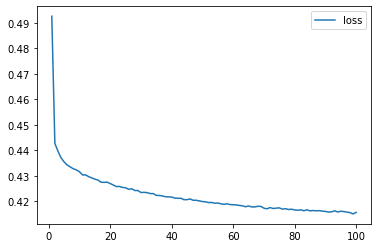

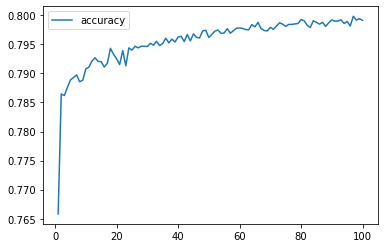

In [7]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
display(history_df.plot(y="loss"))

# Plot the accuracy
display(history_df.plot(y="accuracy"))